In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import Sequence
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/FRAI/dataset/train"
VAL_DIR   = "/content/drive/MyDrive/FRAI/dataset/val"
TEST_DIR  = "/content/drive/MyDrive/FRAI/dataset/test"

MODEL_PATH = "/content/drive/MyDrive/FRAI/vgg16_finetuned.h5"
SAVE_AT_MODEL_PATH = "/content/drive/MyDrive/FRAI/vgg16_adversarial_trained(0005).h5"

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

AT_EPOCHS = 15
AT_EPSILON = 0.005
MIX_RATIO = 0.2   # 80% clean + 20% adversarial

In [ ]:
# LOAD DATA
# -----------------------
train_gen = ImageDataGenerator(rescale=1./255)
val_gen   = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=True
)

val_data = val_gen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=True
)

test_data = test_gen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=1, class_mode="binary", shuffle=False
)


Found 6984 images belonging to 2 classes.
Found 837 images belonging to 2 classes.
Found 1656 images belonging to 2 classes.


In [ ]:
# LOAD MODEL
# -----------------------
model = load_model(MODEL_PATH)
print("Loaded base model for adversarial training.")

Loaded base model for adversarial training.


In [ ]:
loss_object = BinaryCrossentropy(label_smoothing=0.05)


In [ ]:
# FGSM ATTACK FUNCTION
# -----------------------
@tf.function
def fgsm_signed_grads(model, x_batch, y_batch):
    with tf.GradientTape() as tape:
        tape.watch(x_batch)
        preds = model(x_batch, training=False)
        loss = loss_object(y_batch, preds)
    gradient = tape.gradient(loss, x_batch)
    return tf.sign(gradient)

In [ ]:
def generate_adversarial(model, x_batch, y_batch, eps):
    x_tf = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    y_tf = tf.reshape(tf.cast(y_batch, tf.float32), (-1, 1))

    signed_grad = fgsm_signed_grads(model, x_tf, y_tf)
    adv_x = x_tf + eps * signed_grad
    adv_x = tf.clip_by_value(adv_x, 0, 1)

    return adv_x.numpy(), signed_grad.numpy()

In [ ]:
# ADVERSARIAL MIX DATA GENERATOR
# -----------------------
class AdversarialTrainSequence(Sequence):

    def __init__(self, base_gen, model, eps, mix_ratio=0.5):
        self.gen = base_gen
        self.model = model
        self.eps = eps
        self.mix_ratio = mix_ratio
        self.batch_size = base_gen.batch_size

    def __len__(self):
        return len(self.gen)

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen[idx]
        n = x_batch.shape[0]
        n_adv = int(self.mix_ratio * n)

        if n_adv > 0:
            adv_images, _ = generate_adversarial(self.model, x_batch[:n_adv], y_batch[:n_adv], self.eps)
            clean_images = x_batch[n_adv:]
            clean_labels = y_batch[n_adv:]
            x_out = np.concatenate([clean_images, adv_images], axis=0)
            y_out = np.concatenate([clean_labels, y_batch[:n_adv]], axis=0)
        else:
            x_out, y_out = x_batch, y_batch

        # shuffle batch
        idxs = np.random.permutation(len(x_out))
        return x_out[idxs], y_out[idxs]

In [ ]:
# CREATE ADVERSARIAL TRAIN SEQUENCE
# -----------------------
adv_train_seq = AdversarialTrainSequence(
    base_gen=train_data,
    model=model,
    eps=AT_EPSILON,
    mix_ratio=MIX_RATIO
)


In [ ]:
# CALLBACKS
# -----------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint(SAVE_AT_MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1)
]

In [ ]:
# COMPILE MODEL FOR AT
# -----------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# ADVERSARIAL TRAINING
# -----------------------
history = model.fit(
    adv_train_seq,
    validation_data=val_data,
    epochs=AT_EPOCHS,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5226s 24s/step - accuracy: 0.6880 - loss: 0.8185 - val_accuracy: 0.7097 - val_loss: 0.6201
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 325ms/step - accuracy: 0.7150 - loss: 0.6240 - val_accuracy: 0.7204 - val_loss: 0.6016
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 326ms/step - accuracy: 0.7271 - loss: 0.5879 - val_accuracy: 0.7264 - val_loss: 0.5889
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 333ms/step - accuracy: 0.7469 - loss: 0.5675 - val_accuracy: 0.7276 - val_loss: 0.5816
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 322ms/step - accuracy: 0.7626 - loss: 0.5323 - val_accuracy: 0.7431 - val_loss: 0.5697
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 326ms/step - accuracy: 0.7670 - loss: 0.5088 - val_accuracy: 0.7455 - val_loss: 0.5717
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.7886 - loss: 0.4748 - val_accuracy: 0.7300 - val_loss: 0.5795
Epoch 8/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 325ms/step - accuracy: 0.7990 - loss: 0

In [ ]:
model.save(SAVE_AT_MODEL_PATH)
print("Adversarially trained model saved:", SAVE_AT_MODEL_PATH)

Adversarially trained model saved: /content/drive/MyDrive/FRAI/vgg16_adversarial_trained(0005).h5


In [ ]:
# ---- CLEAN TEST ACCURACY ----
test_loss_clean, test_acc_clean = model.evaluate(test_data, verbose=1)
print(f"\nClean Test Accuracy After AT: {test_acc_clean*100:.2f}%")

1656/1656 ━━━━━━━━━━━━━━━━━━━━ 1158s 698ms/step - accuracy: 0.8136 - loss: 0.4898

Clean Test Accuracy After AT: 78.74%


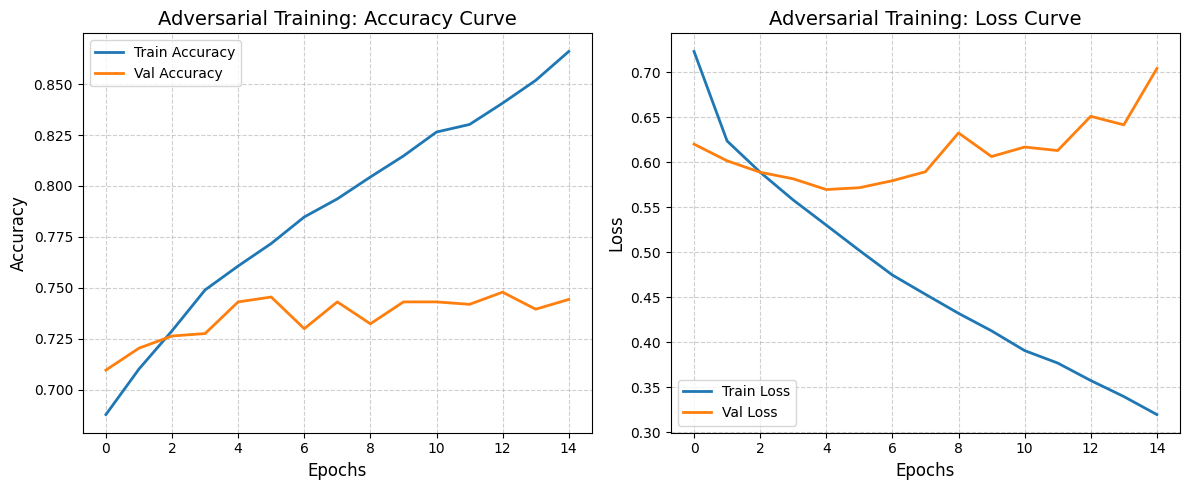

In [ ]:
plt.figure(figsize=(12,5))

# --------------------
# Accuracy Curve
# --------------------
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title("Adversarial Training: Accuracy Curve", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# --------------------
# Loss Curve
# --------------------
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title("Adversarial Training: Loss Curve", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.savefig("adversarial_training_accuracy_loss.png", dpi=300)
plt.show()